<a href="https://colab.research.google.com/github/agrawalabr/deeplearning/blob/main/demo01_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Transformers(VIT) | Transformers in Computer Vision

Transformer architectures, originally designed for Natural Language Processing (NLP), have revolutionized the field of deep learning, forming the backbone of state-of-the-art models across various NLP applications. More recently, these architectures have been successfully adapted to computer vision tasks, leading to a new paradigm in image processing.

The [Vision Transformer (ViT)](https://arxiv.org/pdf/2010.11929), gained large attention in 2021, demonstrates how standard transformer architectures can achieve competitive performance on image classification tasks. The core idea is to split an image into smaller patches, treat each patch as a token, and process them using a sequence of self-attention-based transformer blocks. This approach eliminates the need for traditional convolutional neural networks (CNNs), offering a more flexible and scalable framework for vision tasks.

However, working with ViTs presents a few challenges:
- Computational Complexity: ViTs require significantly more computational resources compared to CNNs due to their high number of parameters. Training from scratch demands large-scale datasets and extensive GPU/TPU resources.
- Interpretability: Unlike CNNs, which leverage spatial hierarchies, transformers rely on global attention mechanisms, making them even more difficult to interpret.
-	Pretraining Dependency: In most practical scenarios, ViTs are pre-trained on massive datasets (e.g., ImageNet-21k, JFT-300M) before being fine-tuned on specific downstream tasks. Training from scratch is feasible but often impractical for smaller datasets.

Despite these challenges, ViTs have shown impressive results in image classification, object detection, and segmentation, signaling a shift in deep learning methodologies for vision tasks. In this notebook, we will explore how to build a Vision Transformer from scratch, gaining insights into its structure, training requirements, and performance characteristics.

- Name: Abhishek Agrawal
- NetId: aa9360

In [1]:
!pip install einops
!pip install torchinfo

In [16]:
import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import torchvision
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [3]:
torch.manual_seed(42)
DOWNLOAD_PATH = './data'
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000
MEAN = 0.2859
STD = 0.3530

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainingdata = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testdata = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=64,shuffle=True)
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=64,shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 208kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.65MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.0MB/s]


In [6]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

In [17]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')

        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
            PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
            PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width), nn.Linear(patch_dim, dim),)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, num_classes))

    def forward(self, img):

        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat([cls_tokens, x], dim=1)

        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [ ]:
model = ViT(image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=6, heads=4, mlp_dim=128)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
from torch.cuda.amp import autocast, GradScaler
scaler = GradScaler()

heads_list = [2,3,4]
depth_list = [4,5,6,7,8]

for heads in heads_list:
    for depth in depth_list:
        print(f"\n Testing config: heads={heads}, depth={depth}")

        model = ViT(image_size=28, patch_size=4, num_classes=10, channels=1, dim=64, depth=depth, heads=heads, mlp_dim=128)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            model.train()
            total_train = 0
            correct_train = 0
            running_loss = 0.0

            for images, labels in tqdm(trainDataLoader, desc=f"Epoch {epoch+1}/{num_epochs} - Train", leave=False):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                # Mixed precision
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

            train_acc = correct_train / total_train
            train_loss = running_loss / len(trainDataLoader)

            model.eval()
            total_test = 0
            correct_test = 0
            test_loss = 0.0

            with torch.no_grad():
                for images, labels in testDataLoader:
                    images, labels = images.to(device), labels.to(device)
                    with torch.cuda.amp.autocast():
                        outputs = model(images)
                        loss = loss_fn(outputs, labels)
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct_test += (predicted == labels).sum().item()
                    total_test += labels.size(0)

            test_acc = correct_test / total_test
            test_loss /= len(testDataLoader)

            print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

        # Store best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = deepcopy(model.state_dict())
            best_config = {'heads': heads, 'depth': depth}

Epoch 1/30 | Train Loss: 0.5959, Train Acc: 0.7824 | Test Loss: 0.4513, Test Acc: 0.8347


Epoch 2/30 | Train Loss: 0.3965, Train Acc: 0.8548 | Test Loss: 0.4339, Test Acc: 0.8429


Epoch 3/30 | Train Loss: 0.3608, Train Acc: 0.8671 | Test Loss: 0.3844, Test Acc: 0.8599


Epoch 4/30 | Train Loss: 0.3370, Train Acc: 0.8751 | Test Loss: 0.3826, Test Acc: 0.8518


Epoch 5/30 | Train Loss: 0.3200, Train Acc: 0.8811 | Test Loss: 0.3547, Test Acc: 0.8663


Epoch 6/30 | Train Loss: 0.3037, Train Acc: 0.8878 | Test Loss: 0.3574, Test Acc: 0.8740


Epoch 7/30 | Train Loss: 0.2892, Train Acc: 0.8923 | Test Loss: 0.3434, Test Acc: 0.8745


Epoch 8/30 | Train Loss: 0.2790, Train Acc: 0.8963 | Test Loss: 0.3450, Test Acc: 0.8728


Epoch 9/30 | Train Loss: 0.2673, Train Acc: 0.8985 | Test Loss: 0.3513, Test Acc: 0.8714


Epoch 10/30 | Train Loss: 0.2558, Train Acc: 0.9046 | Test Loss: 0.3334, Test Acc: 0.8795


Epoch 11/30 | Train Loss: 0.2482, Train Acc: 0.9053 | Test Loss: 0.3310, Test Acc: 0.8817


Epoch 12/30 | Train Loss: 0.2363, Train Acc: 0.9105 | Test Loss: 0.3374, Test Acc: 0.8831


Epoch 13/30 | Train Loss: 0.2283, Train Acc: 0.9150 | Test Loss: 0.3392, Test Acc: 0.8829


Epoch 14/30 | Train Loss: 0.2181, Train Acc: 0.9169 | Test Loss: 0.3246, Test Acc: 0.8888


Epoch 15/30 | Train Loss: 0.2100, Train Acc: 0.9212 | Test Loss: 0.3279, Test Acc: 0.8884


Epoch 16/30 | Train Loss: 0.2019, Train Acc: 0.9228 | Test Loss: 0.3390, Test Acc: 0.8855


Epoch 17/30 | Train Loss: 0.1954, Train Acc: 0.9252 | Test Loss: 0.3344, Test Acc: 0.8853


Epoch 18/30 | Train Loss: 0.1858, Train Acc: 0.9300 | Test Loss: 0.3353, Test Acc: 0.8886


Epoch 19/30 | Train Loss: 0.1798, Train Acc: 0.9312 | Test Loss: 0.3442, Test Acc: 0.8832


Epoch 20/30 | Train Loss: 0.1706, Train Acc: 0.9353 | Test Loss: 0.3568, Test Acc: 0.8747


Epoch 21/30 | Train Loss: 0.1644, Train Acc: 0.9377 | Test Loss: 0.3536, Test Acc: 0.8862


Epoch 22/30 | Train Loss: 0.1587, Train Acc: 0.9395 | Test Loss: 0.3343, Test Acc: 0.8943


Epoch 23/30 | Train Loss: 0.1488, Train Acc: 0.9432 | Test Loss: 0.3496, Test Acc: 0.8907


Epoch 24/30 | Train Loss: 0.1440, Train Acc: 0.9457 | Test Loss: 0.3510, Test Acc: 0.8893


Epoch 25/30 | Train Loss: 0.1372, Train Acc: 0.9477 | Test Loss: 0.3832, Test Acc: 0.8825


Epoch 26/30 | Train Loss: 0.1361, Train Acc: 0.9481 | Test Loss: 0.3448, Test Acc: 0.8909


Epoch 27/30 | Train Loss: 0.1270, Train Acc: 0.9526 | Test Loss: 0.3796, Test Acc: 0.8877


Epoch 28/30 | Train Loss: 0.1220, Train Acc: 0.9544 | Test Loss: 0.3994, Test Acc: 0.8815


Epoch 29/30 | Train Loss: 0.1159, Train Acc: 0.9555 | Test Loss: 0.4001, Test Acc: 0.8895


Epoch 30/30 | Train Loss: 0.1123, Train Acc: 0.9574 | Test Loss: 0.3823, Test Acc: 0.8896


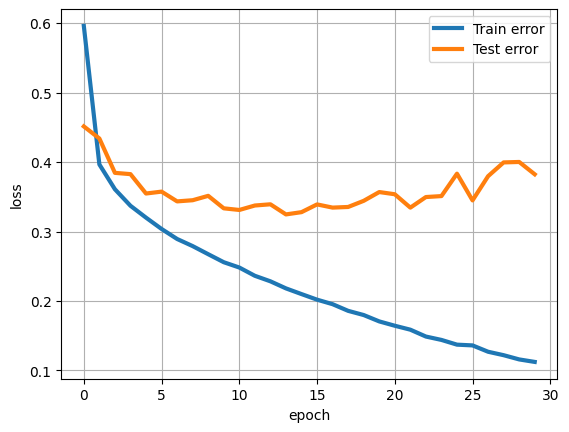

In [20]:
plt.plot(range(30),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(30),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

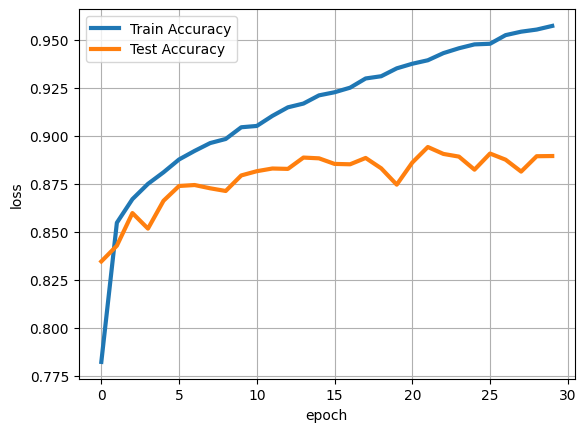

In [21]:
plt.plot(range(30),train_accuracy_history,'-',linewidth=3,label='Train Accuracy')
plt.plot(range(30),test_accuracy_history,'-',linewidth=3,label='Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

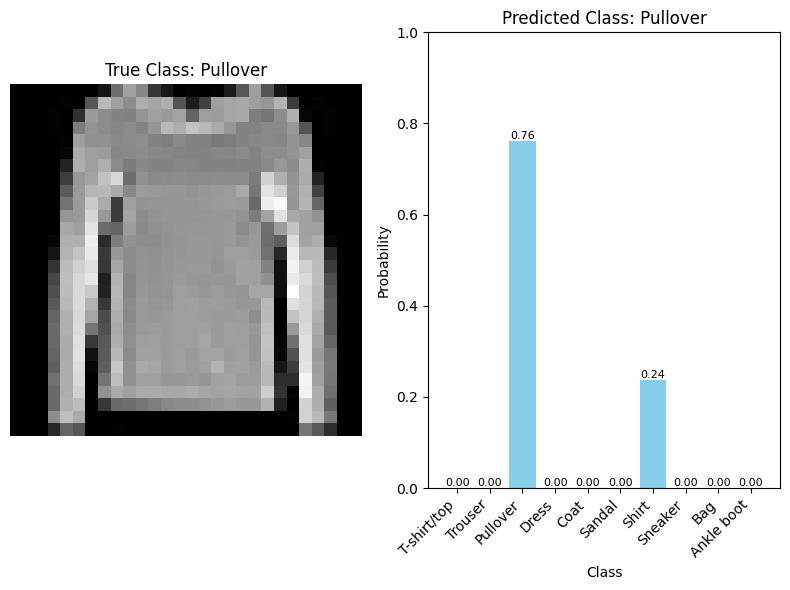

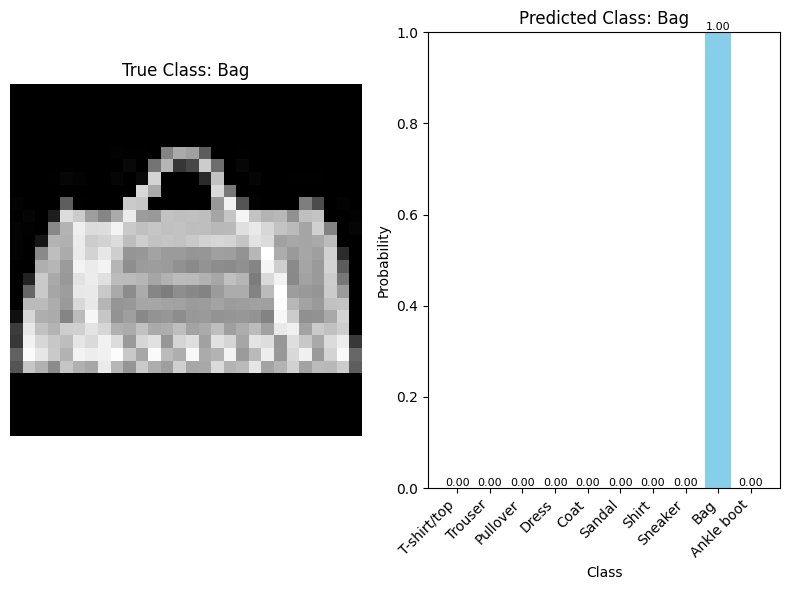

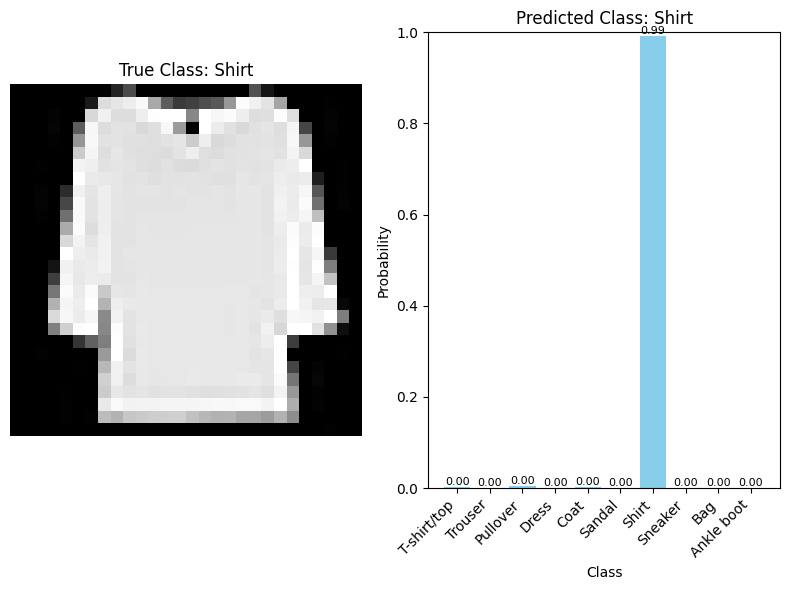

In [25]:
def display_image_with_probabilities(image, probabilities, predicted_class, true_class):
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    plt.figure(figsize=(8, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True Class: {classes[true_class]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    bars = plt.bar(np.arange(len(probabilities)), probabilities, color='skyblue')
    plt.xticks(np.arange(len(probabilities)), classes, rotation=45, ha='right')
    plt.ylabel('Probability')
    plt.xlabel('Class')
    plt.title(f"Predicted Class: {classes[predicted_class]}")
    plt.ylim(0, 1)  # Set y-axis limit to [0, 1]

    for bar, prob in zip(bars, probabilities):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{prob:.2f}', ha='center', va='bottom', color='black', fontsize=8)

    plt.tight_layout()
    plt.show()

model.eval()

sample_indices = np.random.choice(len(testdata), 3, replace=False)
for index in sample_indices:
    image, true_class = testdata[index]
    image_tensor = image.unsqueeze(0).to(next(model.parameters()).device)

    with torch.no_grad():
        predicted_output = model(image_tensor)
        predicted_probabilities = F.softmax(predicted_output, dim=1).squeeze().cpu().numpy()
        predicted_class = torch.argmax(predicted_output, dim=1).item()

    display_image_with_probabilities(image, predicted_probabilities, predicted_class, true_class)